In [1]:
%load_ext autoreload

In [2]:
#coding=utf-8
%autoreload

import numpy as np
import os
import csv
from collections import Counter
import multiprocessing
from multiprocessing import Pool
import re
import pickle
import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gc
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages
import json
import active_search_utilities
import preprocessing_utilities
from scipy.stats import pearsonr

In [3]:
import global_variables

In [4]:
global_variables.init()

In [5]:
all_domains = ['kdd', 'kdd_papers', 'comp', 'fictions', 'acl-both']#, 'acl', 'acl-senior']

In [82]:
#domain = 'kdd'
#domain = 'kdd_papers'
domain = 'comp'
#domain = 'fictions'
#domain = 'acl'
#domain = 'acl-senior'
#domain = 'acl-both'

In [83]:
prefix = '..'

In [84]:
Q = json.load(open(prefix + '/' + domain + '-Q.json', 'r'))
if domain == 'fictions':
    for q in range(len(Q)):
        Q[q] = (list(set(Q[q][0])&sub_V), Q[q][1], Q[q][2])

In [85]:
preprocessed_data = json.load(open(prefix + '/' + domain + '_preprocessed_data.json', 'r'))
sub_V = set(preprocessed_data['sub_V'])
sub_E = set([tuple(x) for x in preprocessed_data['sub_E']])
sub_adj_list = preprocessed_data['sub_adj_list']
global_variables.vertex_to_code = preprocessed_data['vertex_to_code']
global_variables.embedding = np.array(preprocessed_data['embedding'])
global_variables.code_to_vertex = {v:k for k, v in global_variables.vertex_to_code.items()}
global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
global_variables.V_sims = np.load(prefix + '/' + domain + '_V_sims.npy')

In [87]:
# for ACL dataset (swapped lfs vs hfs in filenames isn't a typo!!! - just a current stub)
if domain == 'acl':
    global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_lfs.json', 'r'))
    global_variables.all_lfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
elif domain == 'acl-senior' or domain == 'acl-both':
    global_variables.all_hfs = json.load(open(prefix + '/' + domain + '_hfs.json', 'r'))
    global_variables.all_lfs = json.load(open(prefix + '/' + domain + '_lfs.json', 'r'))

In [88]:
global_variables.all_lfs = [np.array(x) for x in global_variables.all_hfs]

In [89]:
Lambda = 100
lambda_low = 0 # special case for counting only high fidelity steps whereas low fidelities are queried *param* times per h.f.-step
lambda_high = 1.0
INITIAL_SEED_SET_SIZES = [5]

In [77]:
do_randomstart = False
if do_randomstart:
    random_or_intended_start = 'randomstart'
else:
    random_or_intended_start = 'intendedstart'

In [90]:
random_or_intended_start = 'randomstart'

In [91]:
# only for INITIAL_SEED_SET_SIZE = 5
if domain == 'kdd':
    prior_random_for_all_tests = ['7BF1E508', '79AF60E7', '7E686170', '7F51C438', '1DEC6958']
elif domain == 'kdd_papers':
    prior_random_for_all_tests = ['60DC76D2', '80FF7C7F', '7E8F6385', '7752D599', '80F6983C']
elif domain == 'comp':
    prior_random_for_all_tests = ['81537778888748', '55497452495348', '77805587808648', '78878788805048', '8190507248']
elif domain == 'fictions':
    prior_random_for_all_tests = ['77667856756748', '83767053497248', '87534966486748', '75805252896648', '787650844948']
elif domain == 'acl':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']
elif domain == 'acl-senior':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']
elif domain == 'acl-both':
    prior_random_for_all_tests = ['P06-1013', 'P06-1010', 'P03-1055', 'P06-1051', 'P06-1124']

In [94]:
test_params_set = []
for q in range(0, len(Q)):
    for INITIAL_SEED_SET_SIZE in INITIAL_SEED_SET_SIZES:
        test_params_set.append((q, INITIAL_SEED_SET_SIZE))

In [72]:
def test_algorithm(algorithm, alg_params = {}, prefix = ''):
    for p in test_params_set:
        q, INITIAL_SEED_SET_SIZE = p

        print('======================================================')
        print('START TEST:', q, INITIAL_SEED_SET_SIZE)

        interest_nodes = Q[q][0]
        interest_codes = [global_variables.vertex_to_code[v] for v in interest_nodes]
        seed_set_high = []
        if do_randomstart:
            rnd = prior_random_for_all_tests
        else:
            #rnd = #Q[q][0][:INITIAL_SEED_SET_SIZE]
            rnd = prior_random_for_all_tests
        for i in range(INITIAL_SEED_SET_SIZE):   
            seed_set_high.append((global_variables.vertex_to_code[rnd[i]], 
                                  active_search_utilities.high_fidelity_experimental(q, global_variables.vertex_to_code[rnd[i]])\
                                  + np.random.randn()*0.00001))
        seed_set_low = [(c, active_search_utilities.low_fidelity_experimental(q, c, seed_set_high)) for c, _ in seed_set_high]
        if algorithm == 'labelprop':
            logger = active_search_utilities.run_test_labelprop(Q, q, Lambda, lambda_high, seed_set_high,
                                                               alg_params['n_neighbours'])
        elif algorithm == 'gplapl':
            logger = active_search_utilities.run_test_gplapl(Q, q, Lambda, lambda_high, seed_set_high, 
                                                             alg_params['alpha'])
        elif algorithm == 'mfgplapl':
            logger = active_search_utilities.run_test_mfgplapl(Q, q, Lambda, lambda_high, lambda_low, seed_set_high, seed_set_low, 
                                                               alg_params['alpha_high'], alg_params['alpha_low'], alg_params['low_per_high'])
        print(logger['params']['_q'])
        if algorithm == 'labelprop':
            suffix = '_' + str(global_variables.embedding.shape[1]) + 'D'
        elif algorithm == 'mfgplapl':
            suffix = '_' + str(alg_params['low_per_high'])
        else:
            suffix = ''
        pickle.dump(logger, open('../loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                 + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix + '.pkl', 'wb'))


In [ ]:
for alpha in np.logspace(-4, 1, 6):
    test_algorithm('gplapl', {'alpha':alpha}, prefix='alpha_' + str(alpha) + '_')

In [95]:
old_loggers_prefix = '..'

In [96]:
alphas = np.logspace(-4, 1, 6)
lph_stats = {'gplapl_' + str(alpha):[] for alpha in alphas}
clrs = ['b', 'g', 'r', 'yellow', 'cyan', 'magenta', 'black']   
LPH = 10
suffix = ''
for top_k in [100 + 5 - 1]:
    #plt.figure(figsize = (5, 3))
    #plt.title('test all' + '\n' + 'top_k = ' + str(top_k))
    for q in range(0,len(Q)):
        
        
        oracle = sorted(global_variables.all_hfs[q], reverse=True)
        cur_stat = []
        logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + 'alpha_0.001_' + 'gplapl' + '_' + str(q) + '_' \
                                     + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix +'.pkl', 'rb'), encoding='latin1')
        
        for i, it in enumerate(logger['iter_data']):
            expected_val = 0
            RUN = 50
            for rand_gen in range(RUN):
                random_pick = np.random.choice(len(global_variables.all_hfs[q]), 
                                               len(logger['iter_data'][i]['seed_set_high']), 
                                               replace = False)
                utilities = [global_variables.all_hfs[q][x] for x in random_pick]
                expected_val += np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1])
            cur_stat.append(expected_val/RUN)
        rand_stat = np.array(cur_stat)
        clr_id = 0
            
        #add algs:
        for algorithm in ['gplapl']:
            for alpha in [str(x) for x in alphas]:
                
                prefix = 'alpha_' + alpha + '_'
                
                low_per_high = 0
                
                
                logger = pickle.load(open(old_loggers_prefix + '/loggers/' + domain + '/' + prefix + algorithm + '_' + str(q) + '_' \
                                     + str(INITIAL_SEED_SET_SIZE) + '_' + random_or_intended_start + suffix +'.pkl', 'rb'), encoding='latin1')

                cur_stat = []
                for i, it in enumerate(logger['iter_data']):
                    if logger['iter_data'][i]['iteration'] % (low_per_high + 1) == 0:
                        #utilities = [global_variables.all_hfs[q][x[0]] for x in logger['iter_data'][i]['seed_set_high']]
                        utilities = [x[1] for x in logger['iter_data'][i]['seed_set_high']]
                        cur_stat.append(np.mean(oracle[:np.min([len(utilities), top_k])]) - np.mean(sorted(utilities)[:-(top_k + 1):-1]))

                #plt.plot(np.divide(cur_stat, rand_stat), color = clrs[clr_id], alpha = 0.3)
                lph_stats[algorithm + '_' + alpha].append(np.divide(cur_stat, rand_stat))
                clr_id += 1

   

In [97]:
linestyles = ['-', '--', ':']

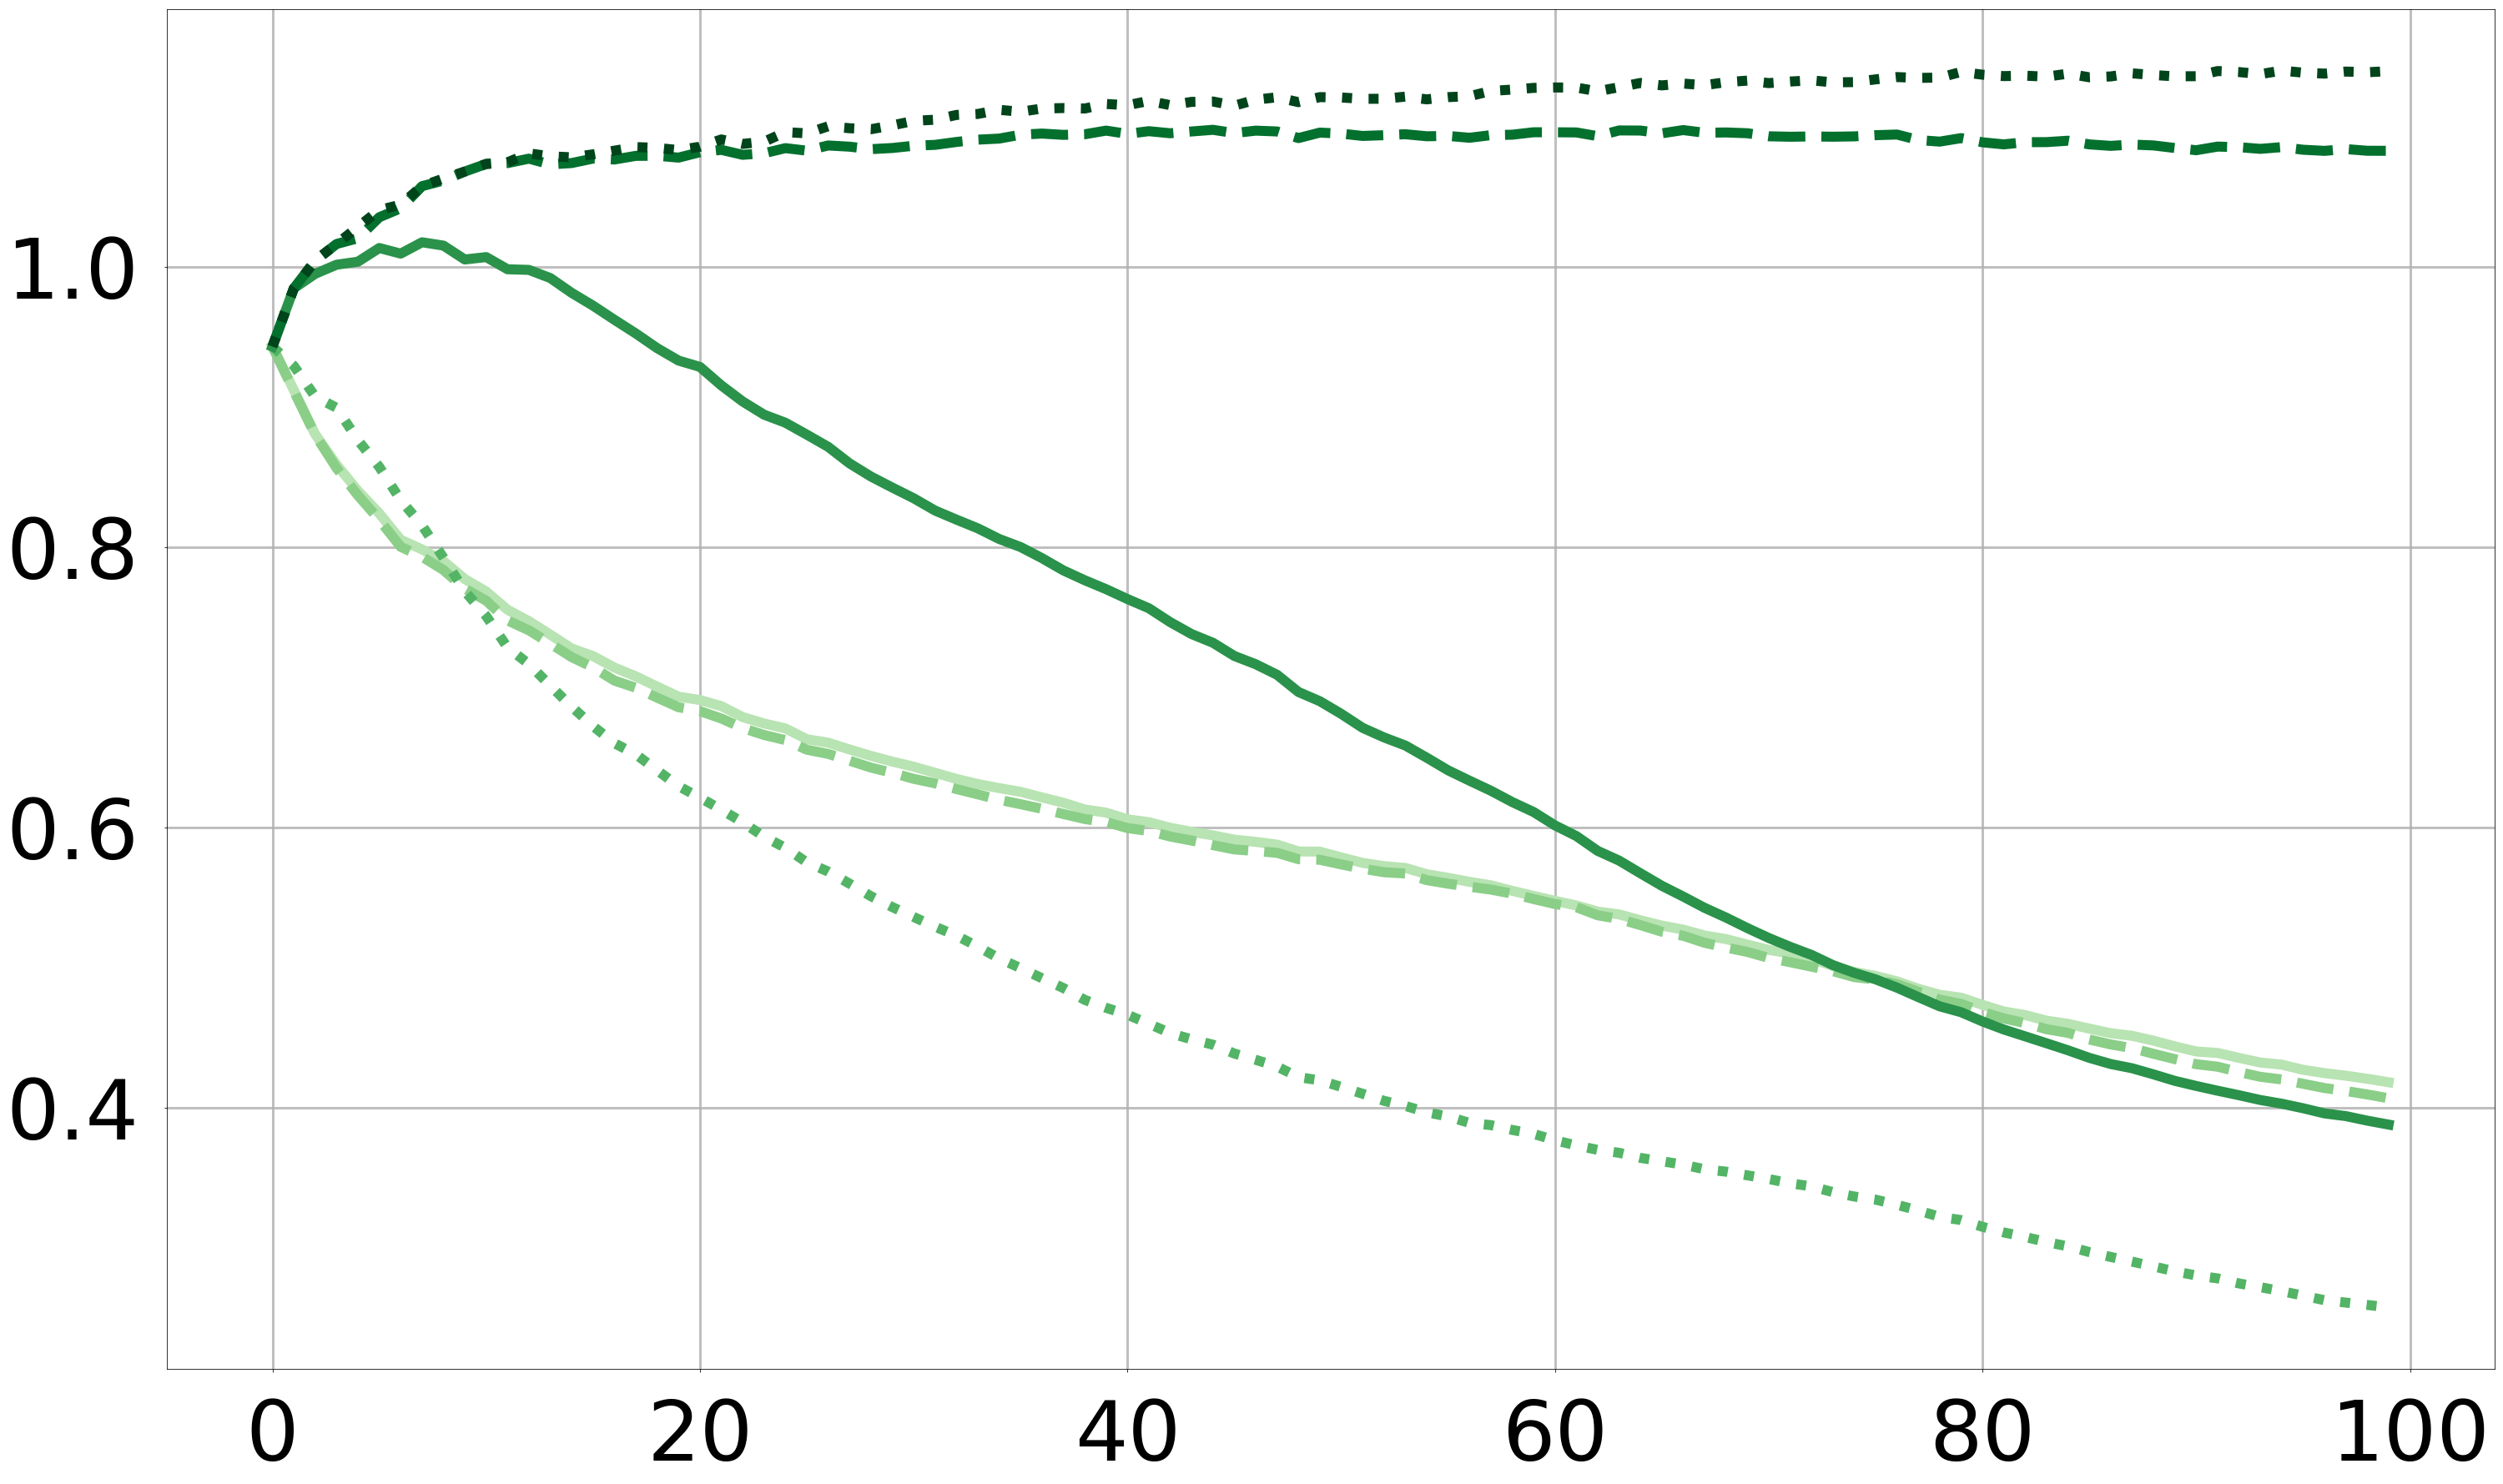

In [98]:
clrs = [cm.Greens(0.7*(i/5.)+ 0.3) for i in range(len(alphas))]

pp = PdfPages('performance_'+domain+'_tuning_beta.pdf')

clr_id = 0
LW_MEAN = 12
LW_Q =4
curve_labels = []
for algorithm in ['gplapl']:
    for alpha in [str(x) for x in alphas]:
        curve_labels.append(algorithm + '_' + alpha )
plt.figure(figsize = (50, 30))

for algorithm in curve_labels:

    plt.plot(np.mean(lph_stats[algorithm], axis = 0), color = clrs[clr_id], label = curve_labels[clr_id], 
             linewidth = LW_MEAN, linestyle=linestyles[clr_id % len(linestyles)])
    clr_id += 1


plt.tick_params(axis='both', which='major', labelsize=100)
plt.gca().grid(which='major', alpha=0.8, linewidth = 3)  
#plt.ylim([0, 1.3])
#plt.legend(fontsize = 80)
plt.gca().tick_params(axis='x', pad=30)
plt.gca().tick_params(axis='y', pad=30)
pp.savefig()
pp.close()